# Loan propensity prediction model
### Peilun (Ann) Liu, Niaoniao Ma, Susannah Schulze

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing
from statsmodels.regression import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC

In [3]:
# Load data

data = pd.read_csv("households_data.csv", encoding='latin-1')
data.head()

,loan,hh,village,religion,roof,rooms,beds,electricity,ownership,leader,connections
0,0,1001,1,hindu,tile,3,4,0,OWNED,0,10
1,0,1002,1,hindu,tile,1,1,1,OWNED,1,14
2,0,1003,1,hindu,rcc,3,4,1,OWNED,1,4
3,0,1004,1,hindu,tile,2,6,1,OWNED,0,8
4,0,1005,1,hindu,tile,3,4,1,OWNED,0,16


In [4]:
# Checking for nulls
data.isnull().values.any()

False

In [5]:
# Creating dummies
rel_dummy = pd.get_dummies(data['religion']).iloc[:, 0:2]
rm_dummy = pd.get_dummies(data['roof']).iloc[:, 1:]
own_dummy = pd.get_dummies(data['ownership']).iloc[:, 1:]
# Drop hh colums
data_drop = data.drop(['hh', 'religion', 'roof', 'ownership'], axis =1)
# Updating table
table = pd.concat([data_drop, rel_dummy, rm_dummy, own_dummy], axis = 1)
table.head()

,loan,village,rooms,beds,electricity,leader,connections,christian,hindu,rcc,sheet,stone,thatch,tile,LEASED,OWNED,RENTED,SHARE_OWNED
0,0,1,3,4,0,0,10,0,1,0,0,0,0,1,0,1,0,0
1,0,1,1,1,1,1,14,0,1,0,0,0,0,1,0,1,0,0
2,0,1,3,4,1,1,4,0,1,1,0,0,0,0,0,1,0,0
3,0,1,2,6,1,0,8,0,1,0,0,0,0,1,0,1,0,0
4,0,1,3,4,1,0,16,0,1,0,0,0,0,1,0,1,0,0


In [5]:
data.shape

(8622, 11)

In [6]:
table.shape

(8622, 18)

In [7]:
data.describe()

,loan,hh,village,rooms,beds,electricity,leader,connections
count,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000
mean,0.145558,41158.936906,41.038854,2.349107,0.867548,0.928671,0.117606,18.633496
std,0.352683,21308.107236,21.306334,1.300611,1.403954,0.257389,0.322160,15.274832
min,0.000000,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25097.250000,25.000000,2.000000,0.000000,1.000000,0.000000,6.000000
50%,0.000000,43029.500000,43.000000,2.000000,0.000000,1.000000,0.000000,16.000000
75%,0.000000,59078.750000,59.000000,3.000000,1.000000,1.000000,0.000000,28.000000
max,1.000000,75172.000000,75.000000,19.000000,50.000000,1.000000,1.000000,180.000000


# EDA

In [8]:
# Looking at correlations
data[data.columns[:]].corr()

,loan,hh,village,rooms,beds,electricity,leader,connections
loan,1.000000,-0.028468,-0.028245,-0.050608,-0.048439,0.001940,0.048395,0.015696
hh,-0.028468,1.000000,0.999994,0.126128,-0.126510,0.027503,0.014635,0.112225
village,-0.028245,0.999994,1.000000,0.126020,-0.126588,0.027453,0.014577,0.112406
rooms,-0.050608,0.126128,0.126020,1.000000,0.420386,0.161366,0.111567,0.194857
beds,-0.048439,-0.126510,-0.126588,0.420386,1.000000,0.107708,0.068810,0.113672
electricity,0.001940,0.027503,0.027453,0.161366,0.107708,1.000000,0.046622,0.086493
leader,0.048395,0.014635,0.014577,0.111567,0.068810,0.046622,1.000000,0.152643
connections,0.015696,0.112225,0.112406,0.194857,0.113672,0.086493,0.152643,1.000000


In [9]:
table[table.columns[:]].corr()

,loan,village,rooms,beds,electricity,leader,connections,christian,hindu,rcc,sheet,stone,thatch,tile,LEASED,OWNED,RENTED,SHARE_OWNED
loan,1.000000,-0.028245,-0.050608,-0.048439,0.001940,0.048395,0.015696,0.011329,-0.069555,-0.038993,-0.004572,-0.001454,0.007491,0.030038,0.006445,-0.011755,0.001245,-0.000220
village,-0.028245,1.000000,0.126020,-0.126588,0.027453,0.014577,0.112406,-0.012476,0.049660,-0.011375,-0.037432,-0.098662,-0.005577,0.200901,-0.017189,0.041610,-0.048749,-0.054394
rooms,-0.050608,0.126020,1.000000,0.420386,0.161366,0.111567,0.194857,-0.010783,0.030720,0.269557,-0.029222,-0.007919,-0.125343,-0.076312,0.001634,0.062234,-0.081379,0.036702
beds,-0.048439,-0.126588,0.420386,1.000000,0.107708,0.068810,0.113672,-0.006013,0.012850,0.194909,-0.001732,0.001716,-0.071941,-0.084906,-0.002009,0.015375,-0.024756,0.029226
electricity,0.001940,0.027453,0.161366,0.107708,1.000000,0.046622,0.086493,0.007900,-0.018841,0.070990,-0.003046,0.049134,-0.253088,0.008222,0.011570,0.060664,-0.033067,-0.046181
leader,0.048395,0.014577,0.111567,0.068810,0.046622,1.000000,0.152643,0.002234,0.010495,0.058117,-0.004666,0.021071,-0.025372,-0.038781,0.002038,0.032076,-0.039589,0.004090
connections,0.015696,0.112406,0.194857,0.113672,0.086493,0.152643,1.000000,-0.008114,0.057494,0.055472,-0.012463,-0.015110,-0.038813,0.007715,-0.018859,0.054420,-0.070536,-0.014797
christian,0.011329,-0.012476,-0.010783,-0.006013,0.007900,0.002234,-0.008114,1.000000,-0.123364,0.003082,-0.003584,0.008816,0.023460,-0.011824,-0.001190,-0.019222,0.012062,-0.002688
hindu,-0.069555,0.049660,0.030720,0.012850,-0.018841,0.010495,0.057494,-0.123364,1.000000,0.006264,-0.021347,-0.020948,0.023880,0.024850,-0.041105,0.093689,-0.101579,-0.029121
rcc,-0.038993,-0.011375,0.269557,0.194909,0.070990,0.058117,0.055472,0.003082,0.006264,1.000000,-0.170848,-0.222852,-0.052541,-0.250799,-0.005686,0.034853,-0.024441,0.002807


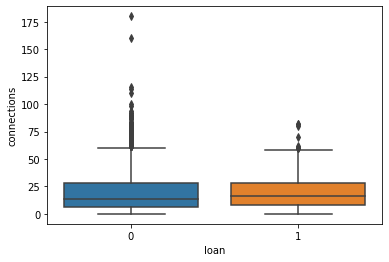

In [6]:
# Looking at variable relationships through basic plot
loan = table['loan']
conn = table['connections']
data_plot = pd.concat([conn, loan], axis =1)
sns.boxplot( x=table["loan"], y=table["connections"] )

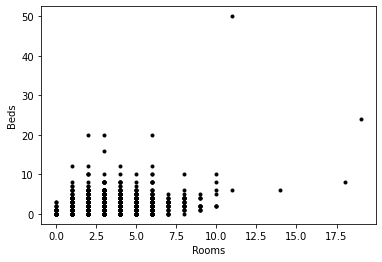

In [7]:
plt.plot(table.rooms, table.beds, '.', color='black')
plt.xlabel('Rooms')
plt.ylabel('Beds');

In [8]:
# OLS
X = table.drop('loan', axis=1)
y = table['loan']
OLS = linear_model.OLS(y, X).fit()
OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   loan   R-squared (uncentered):                   0.151
Model:                            OLS   Adj. R-squared (uncentered):              0.150
Method:                 Least Squares   F-statistic:                              90.24
Date:                Tue, 16 Feb 2021   Prob (F-statistic):                   2.60e-290
Time:                        21:48:09   Log-Likelihood:                         -3218.8
No. Observations:                8622   AIC:                                      6472.
Df Residuals:                    8605   BIC:                                      6592.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
village        -0.0005      0.000     -2.407      0.016      -0.001   -8.43e-05
rooms          -0.0063      0.003     -1.838      0.066      -0.013       0.000
beds           -0.0105      0.003     -3.432      0.001      -0.016      -0.005
electricity     0.0572      0.015      3.946      0.000       0.029       0.086
leader          0.0583      0.012      4.870      0.000       0.035       0.082
connections     0.0007      0.000      2.809      0.005       0.000       0.001
christian       0.0939      0.134      0.701      0.483      -0.169       0.356
hindu          -0.0437      0.016     -2.809      0.005      -0.074      -0.013
rcc             0.0482      0.020      2.415      0.016       0.009       0.087
sheet           0.0794      0.017      4.548      0.000       0.045       0.114
stone           0.0778      0.017      4.599      0.000       0.045       0.111
thatch          0.1193      0.030      4.029      0.000       0.061       0.177
tile            0.0975      0.017      5.714      0.000       0.064       0.131
LEASED          0.1187      0.092      1.285      0.199      -0.062       0.300
OWNED           0.0759      0.018      4.298      0.000       0.041       0.110
RENTED          0.0793      0.023      3.401      0.001       0.034       0.125
SHARE_OWNED     0.0967      0.043      2.233      0.026       0.012       0.182
==============================================================================
Omnibus:                     2900.913   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6988.377
Skew:                           1.969   Prob(JB):                         0.00
Kurtosis:                       4.986   Cond. No.                     1.76e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
# Regressing y on d
OLS2 = linear_model.OLS(y, conn).fit()
OLS2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   loan   R-squared (uncentered):                   0.093
Model:                            OLS   Adj. R-squared (uncentered):              0.092
Method:                 Least Squares   F-statistic:                              879.5
Date:                Tue, 16 Feb 2021   Prob (F-statistic):                   3.96e-184
Time:                        21:48:15   Log-Likelihood:                         -3507.2
No. Observations:                8622   AIC:                                      7016.
Df Residuals:                    8621   BIC:                                      7024.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
connections     0.0048      0.000     29.656      0.000       0.004       0.005
==============================================================================
Omnibus:                     2718.182   Durbin-Watson:                   1.612
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6233.614
Skew:                           1.864   Prob(JB):                         0.00
Kurtosis:                       4.857   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Predicting d hat

In [10]:
# Creating d hat

# Transforming degrees
conn = table['connections']

v = table['village']
v_sq = v**2
v_sq3 = v**3
v2 = v + v_sq
v3 = v2 + v_sq3
rm = table['rooms']
rm_sq = rm**2
rm2 = rm + rm_sq
b = table['beds']
b_sq = b**2
b2 = b + b_sq
e = table['electricity']
e_sq = e**2
e2 = e + e_sq
l = table['leader']
l_sq = l**2
l2 = l + l_sq


In [11]:
# Create interaction terms up to the third degree
mini_table = pd.concat([v,rm,b,e,l], axis = 1)

poly1 = preprocessing.PolynomialFeatures(1, interaction_only=False, include_bias=False)
table_array1 = poly1.fit_transform(mini_table)
target_feature_names1 = ['_x_'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(mini_table.columns,p) for p in poly1.powers_]]
Xd1 = pd.DataFrame(table_array1, columns = target_feature_names1)
Xd1.head()


,village^1,rooms^1,beds^1,electricity^1,leader^1
0,1.0,3.0,4.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,3.0,4.0,1.0,1.0
3,1.0,2.0,6.0,1.0,0.0
4,1.0,3.0,4.0,1.0,0.0


In [12]:
poly2 = preprocessing.PolynomialFeatures(2, interaction_only=False, include_bias=False)
table_array2 = poly2.fit_transform(mini_table)
target_feature_names2 = ['_x_'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(mini_table.columns,p) for p in poly2.powers_]]
Xd2 = pd.DataFrame(table_array2, columns = target_feature_names2)
Xd2.head()

,village^1,rooms^1,beds^1,electricity^1,leader^1,village^2,village^1_x_rooms^1,village^1_x_beds^1,village^1_x_electricity^1,village^1_x_leader^1,rooms^2,rooms^1_x_beds^1,rooms^1_x_electricity^1,rooms^1_x_leader^1,beds^2,beds^1_x_electricity^1,beds^1_x_leader^1,electricity^2,electricity^1_x_leader^1,leader^2
0,1.0,3.0,4.0,0.0,0.0,1.0,3.0,4.0,0.0,0.0,9.0,12.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,3.0,4.0,1.0,1.0,1.0,3.0,4.0,1.0,1.0,9.0,12.0,3.0,3.0,16.0,4.0,4.0,1.0,1.0,1.0
3,1.0,2.0,6.0,1.0,0.0,1.0,2.0,6.0,1.0,0.0,4.0,12.0,2.0,0.0,36.0,6.0,0.0,1.0,0.0,0.0
4,1.0,3.0,4.0,1.0,0.0,1.0,3.0,4.0,1.0,0.0,9.0,12.0,3.0,0.0,16.0,4.0,0.0,1.0,0.0,0.0


In [13]:
poly3 = preprocessing.PolynomialFeatures(3, interaction_only=False, include_bias=False)
table_array3 = poly3.fit_transform(mini_table)
target_feature_names3 = ['_x_'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(mini_table.columns,p) for p in poly3.powers_]]
Xd3 = pd.DataFrame(table_array3, columns = target_feature_names3)
Xd3.head()

,village^1,rooms^1,beds^1,electricity^1,leader^1,village^2,village^1_x_rooms^1,village^1_x_beds^1,village^1_x_electricity^1,village^1_x_leader^1,...,beds^3,beds^2_x_electricity^1,beds^2_x_leader^1,beds^1_x_electricity^2,beds^1_x_electricity^1_x_leader^1,beds^1_x_leader^2,electricity^3,electricity^2_x_leader^1,electricity^1_x_leader^2,leader^3
0,1.0,3.0,4.0,0.0,0.0,1.0,3.0,4.0,0.0,0.0,...,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,3.0,4.0,1.0,1.0,1.0,3.0,4.0,1.0,1.0,...,64.0,16.0,16.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0
3,1.0,2.0,6.0,1.0,0.0,1.0,2.0,6.0,1.0,0.0,...,216.0,36.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,3.0,4.0,1.0,0.0,1.0,3.0,4.0,1.0,0.0,...,64.0,16.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0


In [14]:
ls_mod = LassoLarsCV(cv=5)

In [15]:
# Predicting d hat using different degrees of interction
ls_fit = ls_mod.fit(Xd1,conn)
pred1 = ls_fit.predict(Xd1)
print(np.sqrt(mean_squared_error(conn,pred1)))
print(r2_score(conn,pred1))

14.744666535108633
0.06810404905650358


In [16]:
ls_fit2 = ls_mod.fit(Xd2,conn)
pred2 = ls_fit2.predict(Xd2)
print(np.sqrt(mean_squared_error(conn,pred2)))
print(r2_score(conn,pred2))

14.685387628475876
0.07558210587868486


C:\Users\bengbengbb\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:570: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.789e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\bengbengbb\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:570: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.288e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\bengbengbb\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:570: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations

In [17]:
ls_fit3 = ls_mod.fit(Xd3,conn)
pred3 = ls_fit3.predict(Xd3)
print(np.sqrt(mean_squared_error(conn,pred3)))
print(r2_score(conn,pred3))

14.735469654566929
0.06926621339741557


C:\Users\bengbengbb\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:570: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.637e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\bengbengbb\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:570: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.637e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\bengbengbb\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:570: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.

In [18]:
# interaction to the second degree has the best performance so we will use that to create our d hat
lasso_coeff = pd.DataFrame()
lasso_coeff["Variables"] = Xd2.columns
lasso_coeff["Coefficient Estimate"] = pd.Series(ls_mod.coef_)
print(lasso_coeff)

                    Variables  Coefficient Estimate
0                   village^1              0.000000
1                     rooms^1              0.000000
2                      beds^1             -1.346689
3               electricity^1              0.000000
4                    leader^1              0.000000
5                   village^2              0.000000
6         village^1_x_rooms^1              0.000000
7          village^1_x_beds^1              0.012229
8   village^1_x_electricity^1              0.000000
9        village^1_x_leader^1              0.000000
10                    rooms^2              0.000000
11           rooms^1_x_beds^1              0.000000
12    rooms^1_x_electricity^1              0.719084
13         rooms^1_x_leader^1              1.350495
14                     beds^2              0.000000
15     beds^1_x_electricity^1              0.560074
16          beds^1_x_leader^1              0.504306
17              electricity^2              0.000000
18   electri

# Two step lasso

In [19]:
from scipy.optimize import minimize

dhat = pd.DataFrame(pred2) # using pred2 as dhat
d = conn
A = pd.concat([d, dhat, Xd2], axis = 1)
alphas = list(range(1,50,1)) # change value of alpha --> sequence of values

y = data["loan"] # response variable
x0 = np.zeros(A.shape[1])

weights = np.ones(A.shape[1]) # starting with every column having a weight of 1
weights[[0,1]] = 0.0 # assigning zero weight to d and d_hat so we don't penalize them

choice = pd.DataFrame(columns=['alpha', 'mse'])

for alpha in alphas:
    def lasso(x):  # following sklearn's definition from user-guide!
        return (1. / (2*A.shape[0])) * np.square(np.linalg.norm(A.dot(x) - y, 2)) + alpha * np.linalg.norm(weights*x, 1)

    res = minimize(lasso, x0, method='L-BFGS-B', options={'disp': False})
    m = res.x*A
    y_pred = m.sum(axis = 1)
    mse = mean_squared_error(y, y_pred)
    choice.loc[len(choice.index)] = [alpha, mse]

print(choice)


    alpha       mse
0     1.0  0.127429
1     2.0  0.127738
2     3.0  0.134072
3     4.0  0.134074
4     5.0  0.134075
5     6.0  0.134076
6     7.0  0.134079
7     8.0  0.134080
8     9.0  0.134082
9    10.0  0.134086
10   11.0  0.134086
11   12.0  0.134090
12   13.0  0.134093
13   14.0  0.134125
14   15.0  0.134091
15   16.0  0.134102
16   17.0  0.134133
17   18.0  0.134131
18   19.0  0.134135
19   20.0  0.134119
20   21.0  0.134109
21   22.0  0.134140
22   23.0  0.134139
23   24.0  0.134142
24   25.0  0.134139
25   26.0  0.134159
26   27.0  0.134169
27   28.0  0.134153
28   29.0  0.134127
29   30.0  0.134139
30   31.0  0.134154
31   32.0  0.134155
32   33.0  0.134171
33   34.0  0.134178
34   35.0  0.134228
35   36.0  0.134260
36   37.0  0.134293
37   38.0  0.134274
38   39.0  0.134347
39   40.0  0.134413
40   41.0  0.134314
41   42.0  0.134327
42   43.0  0.134297
43   44.0  0.134329
44   45.0  0.134492
45   46.0  0.134517
46   47.0  0.134561
47   48.0  0.134463
48   49.0  0.134400


In [20]:
print(choice[choice.mse == choice.mse.min()])

   alpha       mse
0    1.0  0.127429


In [48]:
alpha = choice[choice.mse == choice.mse.min()].alpha
dhat = pd.DataFrame(pred2) # using pred3 as dhat
d = conn
A = pd.concat([d, dhat, Xd2], axis = 1)

y = data["loan"] # response variable
x0 = np.zeros(A.shape[1])

weights = np.ones(A.shape[1]) # starting with every column having a weight of 1
weights[[0,1]] = 0.0 # assigning zero weight to d and d_hat so we don't penalize them

def lasso(x):  # following sklearn's definition from user-guide!
    return (1. / (2*A.shape[0])) * np.square(np.linalg.norm(A.dot(x) - y, 2)) + alpha * np.linalg.norm(weights*x, 1)

res = minimize(lasso, x0, method='L-BFGS-B', options={'disp': False})
m = res.x*A
y_pred = m.sum(axis = 1)
   
lasso_2stage_coef = pd.DataFrame()
lasso_2stage_coef["Variables"] = A.columns
lasso_2stage_coef["Coefficient Estimate"] = pd.Series(res.x)
print(lasso_2stage_coef)

                    Variables  Coefficient Estimate
0                 connections          3.101955e-03
1                           0          3.119680e-03
2                   village^1          7.337317e-11
3                     rooms^1         -1.987730e-06
4                      beds^1          4.675798e-06
5               electricity^1          4.311257e-08
6                    leader^1          1.325974e-06
7                   village^2          4.699840e-06
8         village^1_x_rooms^1         -4.137028e-06
9          village^1_x_beds^1         -7.032734e-05
10  village^1_x_electricity^1          5.240260e-07
11       village^1_x_leader^1         -1.044145e-06
12                    rooms^2          6.532678e-08
13           rooms^1_x_beds^1         -2.389802e-07
14    rooms^1_x_electricity^1          1.558592e-06
15         rooms^1_x_leader^1         -1.110958e-06
16                     beds^2          1.935475e-06
17     beds^1_x_electricity^1          6.279434e-06
18          

In [47]:
mse = mean_squared_error(y, y_pred)
print(mse)

0.12742910103971283


In [52]:
# threshold for selecting variables = e-07
lasso_var_retained = pd.concat([d, dhat, Xd2["rooms^1"], Xd2["beds^1"], Xd2["village^2"], Xd2["leader^1"], Xd2["village^2"], 
                                Xd2["village^1_x_rooms^1"], Xd2["village^1_x_beds^1"], Xd2["village^1_x_leader^1"], 
                               Xd2["rooms^1_x_electricity^1"], Xd2["rooms^1_x_leader^1"], Xd2["beds^2"], Xd2["beds^1_x_electricity^1"], 
                               Xd2["beds^1_x_leader^1"], Xd3["leader^2"]], axis = 1)
lasso_var_retained.head()

,connections,0,rooms^1,beds^1,village^2,leader^1,village^2,village^1_x_rooms^1,village^1_x_beds^1,village^1_x_leader^1,rooms^1_x_electricity^1,rooms^1_x_leader^1,beds^2,beds^1_x_electricity^1,beds^1_x_leader^1,leader^2
0,10,13.062720,3.0,4.0,1.0,0.0,1.0,3.0,4.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0
1,14,17.903812,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,4,23.800725,3.0,4.0,1.0,1.0,1.0,3.0,4.0,1.0,3.0,3.0,16.0,4.0,4.0,1.0
3,8,15.596844,2.0,6.0,1.0,0.0,1.0,2.0,6.0,0.0,2.0,0.0,36.0,6.0,0.0,0.0
4,16,16.313300,3.0,4.0,1.0,0.0,1.0,3.0,4.0,0.0,3.0,0.0,16.0,4.0,0.0,0.0


In [53]:
# Linear Reg with variables selected by lasso
x = lasso_var_retained
OLS_2 = linear_model.OLS(y, x).fit()
OLS_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   loan   R-squared (uncentered):                   0.154
Model:                            OLS   Adj. R-squared (uncentered):              0.153
Method:                 Least Squares   F-statistic:                              112.1
Date:                Tue, 16 Feb 2021   Prob (F-statistic):                   1.11e-299
Time:                        22:34:34   Log-Likelihood:                         -3204.0
No. Observations:                8622   AIC:                                      6436.
Df Residuals:                    8608   BIC:                                      6535.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
connections                 0.0006      0.000      2.349      0.019       0.000       0.001
0                           0.0117      0.001     13.000      0.000       0.010       0.013
rooms^1                    -0.0095      0.012     -0.817      0.414      -0.032       0.013
beds^1                      0.0247      0.022      1.149      0.251      -0.017       0.067
village^2               -3.419e-06   2.29e-06     -1.491      0.136   -7.92e-06    1.08e-06
leader^1                    0.0440      0.016      2.728      0.006       0.012       0.076
village^2               -3.419e-06   2.29e-06     -1.491      0.136   -7.92e-06    1.08e-06
village^1_x_rooms^1        -0.0003      0.000     -1.996      0.046      -0.001   -5.26e-06
village^1_x_beds^1         -0.0002      0.000     -1.524      0.128      -0.001     6.3e-05
village^1_x_leader^1        0.0004      0.001      0.759      0.448      -0.001       0.002
rooms^1_x_electricity^1     0.0023      0.009      0.247      0.805      -0.016       0.021
rooms^1_x_leader^1         -0.0399      0.009     -4.597      0.000      -0.057      -0.023
beds^2                      0.0003      0.000      1.898      0.058    -1.1e-05       0.001
beds^1_x_electricity^1     -0.0425      0.021     -1.989      0.047      -0.084      -0.001
beds^1_x_leader^1          -0.0044      0.009     -0.492      0.623      -0.022       0.013
leader^2                    0.0440      0.016      2.728      0.006       0.012       0.076
==============================================================================
Omnibus:                     2921.976   Durbin-Watson:                   1.682
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7079.993
Skew:                           1.981   Prob(JB):                         0.00
Kurtosis:                       5.003   Cond. No.                     1.33e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.34e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

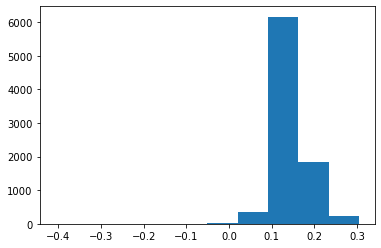

In [54]:
y_pred = OLS_2.predict()
plt.hist(y_pred)
plt.show()

In [55]:
# Calculate MSE
mean_squared_error(y, y_pred)

0.12311316747703073

In [56]:
# actual balance of loan
y.value_counts()

0    7367
1    1255
Name: loan, dtype: int64

In [63]:
# threshold for 0/1 loan
percent_zero = y.value_counts()[0]/y.count()
percent_one = y.value_counts()[1]/y.count()
print(percent_zero, percent_one)

0.8544421247970309 0.14555787520296914


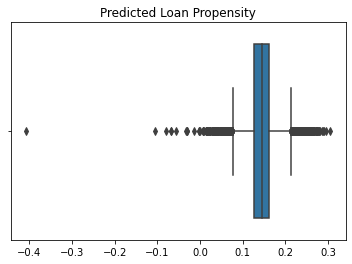

In [57]:
sns.boxplot(y_pred)
plt.title("Predicted Loan Propensity")
plt.show()

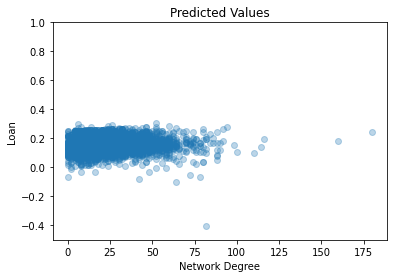

In [58]:
plt.scatter(x = conn, y = y_pred, alpha = 0.3)
plt.xlabel("Network Degree")
plt.ylabel("Loan")
plt.title("Predicted Values")
plt.ylim([-0.5, 1])
plt.show()

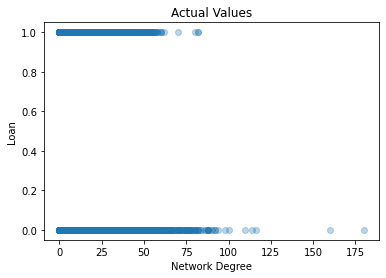

In [59]:
plt.scatter(x = conn, y = y, alpha = 0.3)
plt.xlabel("Network Degree")
plt.ylabel("Loan")
plt.title("Actual Values")
plt.show()

# Naive lasso

In [60]:
naive = pd.concat([dhat, Xd2], axis = 1)
lasso_naive = ls_mod.fit(naive, y)
pred_naive = ls_fit.predict(naive)
print(np.sqrt(mean_squared_error(y, pred_naive)))

0.35266241672365084


C:\Users\bengbengbb\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:570: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.334e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\bengbengbb\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:570: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=4.263e-05, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\bengbengbb\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:570: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.

# Bootstrap

In [61]:
se_boot = []
for i in range(0, 1000):
    sample_index = np.random.choice(range(0, len(y)), len(y))
    x_samples = x.iloc[sample_index]
    y_samples = y[sample_index]
    OLS_boot = linear_model.OLS(y_samples, x_samples).fit()
   
    se_boot.append(OLS_boot.bse['connections'])

se_boot.sort()
print(se_boot[24])
print(se_boot[974])

0.00024953132940558386
0.00026639871322527565
